In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import lanelines
from lanelines import open_image
from calib import find_cbc

In [3]:
CALIB_IM_DIR = 'camera_cal'
CALIB_SERIALIZE_DIR = 'camera_cal_results'

In [4]:
cm = np.load(os.path.join(CALIB_SERIALIZE_DIR, 'camera_matrix.npy'))
dc = np.load(os.path.join(CALIB_SERIALIZE_DIR, 'dist_coefs.npy'))

In [5]:
def undistort_cb_and_find_corners(im, cm, dc, nx, ny):
    
    im_sz = lanelines.get_im_wh(im)
    undist = cv2.undistort(im, cm, dc)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    found_cbc, cbc = find_cbc(gray, pattern_size=(nx, ny))
    return found_cbc, cbc, undist


def warp_chessboard_image(undist_im, nx, ny):
    
    im_sz = lanelines.get_im_wh(undist_im)
        
    canvas = np.copy(undist_im) 
    cv2.drawChessboardCorners(canvas, (nx, ny), cbc, found_cbc)
        
    corners = cbc.reshape(-1, 2)
        
    src_points = lanelines.get_rectangle_corners_from_cbc(corners, nx, ny)
    
    offset_x = im_sz[0] / (nx + 1)
    offset_y = im_sz[1] / (ny + 1)
    
    dst_points = lanelines.get_ractangle_corners_in_image(im_sz, offset_x, offset_y)
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(canvas, M, im_sz, flags=cv2.INTER_LINEAR)

    return warped, M
    

In [6]:
images = [open_image(im) for im in glob(CALIB_IM_DIR + '/*.jpg')]

In [7]:
warped_images = []
M_list = []
for im in images:
    found_cbc, cbc, undist = undistort_cb_and_find_corners(im, cm, dc, nx=9, ny=6)
    if found_cbc:
        warped, M = warp_chessboard_image(undist, nx=9, ny=6)
        
        warped_images.append(warped)
        M_list.append(M)

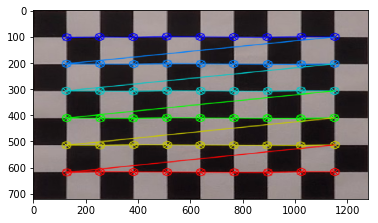

In [8]:
plt.figure()
plt.imshow(warped_images[0])